In [1]:
import os
import NN
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

## Train and Evaluate a single model

### Setup Parameters

In [2]:
ETF = 'DIA' # 'SPY', 'DIA', 'QQQ'
NNtype = 'MLP' # 'MLP', 'RNN', 'PSN'
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype] # SPYfeatures, DIAfeatures, QQQfeatures

### Load Dataframes

In [3]:
traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

### Initialize DataLoaders

In [4]:
features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'


if NNtype != "PSN":
    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()
    
    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

else:
    max_ = traindf.Return.max()
    min_ = traindf.Return.min()
    traindf = (traindf - min_) / (max_ - min_)
    validdf = (validdf - min_) / (max_ - min_)
    testdf = (testdf - min_) / (max_ - min_)

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

### Instanciate Model

In [5]:
model = NN.Model(NNtype)
epochs = 200 if NNtype == "PSN" else 500

model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            epochs,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)


### Training

In [6]:
model.train(trainloader, validloader)

[00:00] Epoch 1/500 - Train Loss : 1.047184 / Val Loss : 1.001686
[00:37] Epoch 100/500 - Train Loss : 0.954827 / Val Loss : 1.015512
[01:15] Epoch 200/500 - Train Loss : 0.857422 / Val Loss : 1.035131
[01:53] Epoch 300/500 - Train Loss : 0.785515 / Val Loss : 1.096755
[02:30] Epoch 400/500 - Train Loss : 0.747479 / Val Loss : 1.153378
[03:08] Epoch 500/500 - Train Loss : 0.705145 / Val Loss : 1.201067
Train MAE : 0.6298 | Train MAPE  : 3.5788 | Train RMSE : 0.8252 | Train Theil-U 0.5483
Valid MAE : 0.8482 | Valid MAPE  : 2.1933 | Valid RMSE : 1.0959 | Valid Theil-U 0.7202


### Evaluation

In [10]:
if NNtype != "PSN":
    model.evaluate(testloader, mu=testmu, sigma=testsigma)
else:
    model.evaluate(testloader, min_=min_, max_=max_)

Normalized Test MAE : 0.006096 | Test MAPE  : 27.835288 | Test RMSE : 0.007963 | Test Theil-U 0.742134


In [9]:
model.evaluate_bis(testloader, mu=testmu, sigma=testsigma)

Normalized Test MAE : 0.006096 | Test MAPE  : 27.835288 | Test RMSE : 0.007963 | Test Theil-U 0.742134


### PREDICT

(array([  7.,  10.,  17.,  82., 102.,  64.,  25.,  10.,   3.,   1.]),
 array([-0.01084351, -0.0084229 , -0.00600229, -0.00358168, -0.00116106,
         0.00125955,  0.00368016,  0.00610077,  0.00852138,  0.010942  ,
         0.01336261]),
 <a list of 10 Patch objects>)

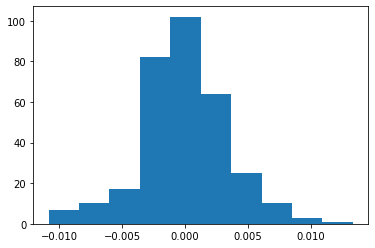

In [11]:
if NNtype != "PSN":
    predictions = model.predict(testloader, mu=testmu, sigma=testsigma)
else:
    predictions = model.predict(testloader, min_=min_, max_=max_)
plt.hist(np.array(predictions))

Text(0.5, 1.0, 'UnNormalized')

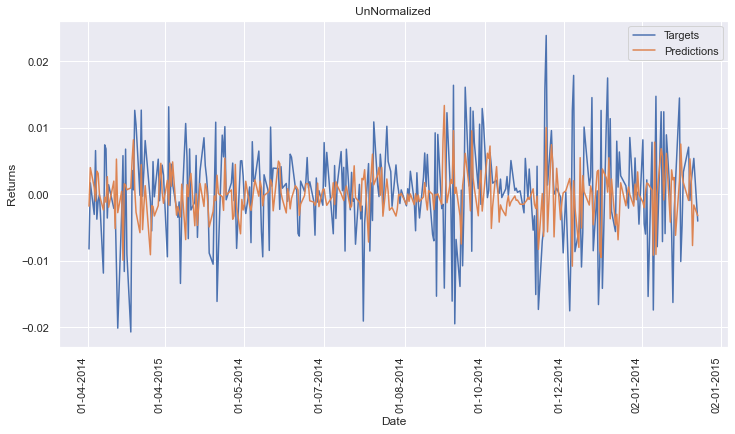

In [13]:
if NNtype == "PSN":
    targets = testdf["Target"]*(max_ - min_) + min_
else :
    targets = testdf["Target"].tolist()

dataDf = pd.DataFrame({'Predictions':predictions, 'Targets':targets})
dataDf.index = testdf.index
dataDf

sns.set()
fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
ax.set_ylabel('Returns')
ax.set_title("UnNormalized")

## Train and Evaluate All Models

In [50]:
ETF = 'QQQ'
NNtype = 'PSN'

print("="*10 + ETF + " - " + NNtype + "="*10)
params = cfg.train_parameters[ETF][NNtype]
if ETF == "SPY":
    inputs_lag = cfg.SPYfeatures[NNtype]
elif ETF == "DIA":
    inputs_lag = cfg.DIAfeatures[NNtype]
elif ETF == "QQQ":
    inputs_lag = cfg.QQQfeatures[NNtype]

traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

if NNtype != "PSN":
    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()
    
    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

else:
    max_ = traindf.Return.max()
    min_ = traindf.Return.min()
    traindf = (traindf - min_) / (max_ - min_)
    validdf = (validdf - min_) / (max_ - min_)
    testdf = (testdf - min_) / (max_ - min_)

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

model = NN.Model(NNtype)
epochs = 200 if NNtype == "PSN" else 500
model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            epochs,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

model.train(trainloader, validloader)

==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.018489 / Val Loss : 0.011347
[00:32] Epoch 100/200 - Train Loss : 0.014463 / Val Loss : 0.005774
[01:03] Epoch 200/200 - Train Loss : 0.014175 / Val Loss : 0.006009
Train MAE : 0.0886 | Train MAPE  : 0.1706 | Train RMSE : 0.1172 | Train Theil-U 0.1027
Valid MAE : 0.0611 | Valid MAPE  : 0.1062 | Valid RMSE : 0.0775 | Valid Theil-U 0.0684


Normalized Test MAE : 0.007384 | Test MAPE  : 4027.963181 | Test RMSE : 0.009217 | Test Theil-U 0.774199
Test MAE : 0.007384 | Test MAPE  : 1808722958671.989990 | Test RMSE : 0.009217 | Test Theil-U 0.774199


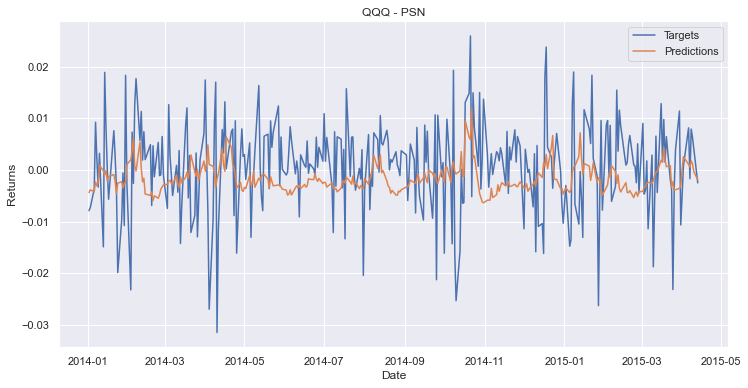

In [51]:
if NNtype == "PSN":
    model.evaluate(testloader, min_=min_, max_=max_)
    preds = model.predict(testloader, min_=min_, max_=max_)
    labels = testdf["Target"]*(max_ - min_) + min_
else :
    model.evaluate(testloader, sigma=testsigma, mu=testmu)
    preds = model.predict(testloader, sigma=testsigma, mu=testmu)
    labels = np.array(testdf["Target"].tolist())

testRMSE = np.sqrt(mean_squared_error(labels, preds))
testMAE = mean_absolute_error(labels, preds)
testMAPE = mean_absolute_percentage_error(labels, preds)
testTheilU = theilU(labels, preds)

print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))

## plot Target and Predictions UnNormalized ##
dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
dataDf.index = testdf.index
dataDf

sns.set()
fig, ax = plt.subplots(figsize = (12,6))
sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

ax.set_ylabel('Returns')
ax.set_title(ETF + " - " + NNtype)
plt.show() 

## Train all Models and create Table4

==========SPY - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.040194 / Val Loss : 1.008898
[00:33] Epoch 100/500 - Train Loss : 0.906623 / Val Loss : 0.987094
[01:04] Epoch 200/500 - Train Loss : 0.878876 / Val Loss : 1.027467
[01:36] Epoch 300/500 - Train Loss : 0.830304 / Val Loss : 1.103579
[02:07] Epoch 400/500 - Train Loss : 0.802571 / Val Loss : 1.222004
[02:38] Epoch 500/500 - Train Loss : 0.797335 / Val Loss : 1.278265
Train MAE : 0.6377 | Train MAPE  : 2.4039 | Train RMSE : 0.8914 | Train Theil-U 0.5987
Valid MAE : 0.8536 | Valid MAPE  : 1.7240 | Valid RMSE : 1.1306 | Valid Theil-U 0.7594
Normalized Test MAE : 0.006015 | Test MAPE  : 2.406805 | Test RMSE : 0.007898 | Test Theil-U 0.726266
Test MAE : 0.006017 | Test M

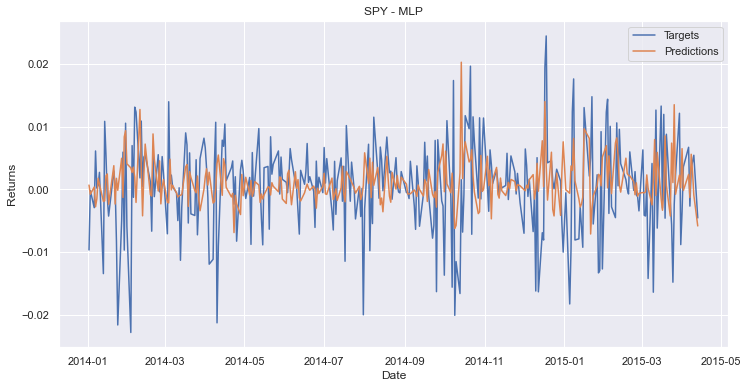




==========SPY - RNN==========
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.097390 / Val Loss : 1.018408
[00:43] Epoch 100/500 - Train Loss : 0.732677 / Val Loss : 1.169187
[01:27] Epoch 200/500 - Train Loss : 0.694728 / Val Loss : 1.179736
[02:12] Epoch 300/500 - Train Loss : 0.684793 / Val Loss : 1.192544
[02:56] Epoch 400/500 - Train Loss : 0.680396 / Val Loss : 1.202241
[03:40] Epoch 500/500 - Train Loss : 0.677880 / Val Loss : 1.206779
Train MAE : 0.6005 | Train MAPE  : 4.1493 | Train RMSE : 0.8039 | Train Theil-U 0.5037
Valid MAE : 0.8425 | Valid MAPE  : 1.8860 | Valid RMSE : 1.0985 | Valid Theil-U 0.6775
Normalized Test MAE : 0.006070 | Test MAPE  : 2.563527 | Test RMSE : 0.008299 | Test Theil-U 0.718525
Test MAE : 0.006107 | Test MAPE  : 202.330861 | Test RMSE : 0.008311 | Test Theil-U 0

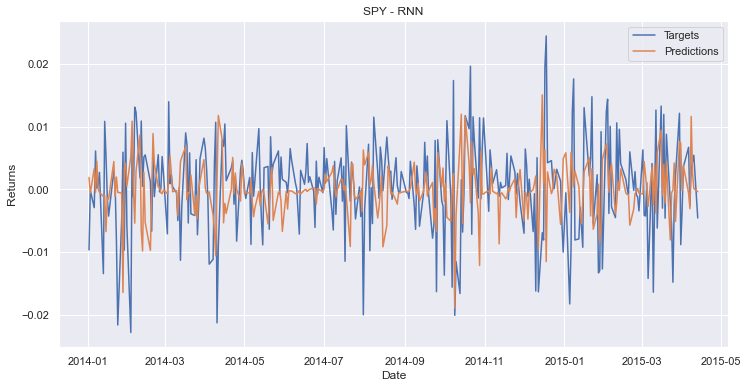




==========SPY - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.015205 / Val Loss : 0.005145
[00:30] Epoch 100/200 - Train Loss : 0.012510 / Val Loss : 0.007674
[01:00] Epoch 200/200 - Train Loss : 0.012619 / Val Loss : 0.007787
Train MAE : 0.0922 | Train MAPE  : 0.1623 | Train RMSE : 0.1207 | Train Theil-U 0.1025
Valid MAE : 0.0750 | Valid MAPE  : 0.1213 | Valid RMSE : 0.0882 | Valid Theil-U 0.0761
Normalized Test MAE : 0.008510 | Test MAPE  : 5.256088 | Test RMSE : 0.009940 | Test Theil-U 0.710256
Test MAE : 0.008510 | Test MAPE  : 525.610331 | Test RMSE : 0.009940 | Test Theil-U 0.710256


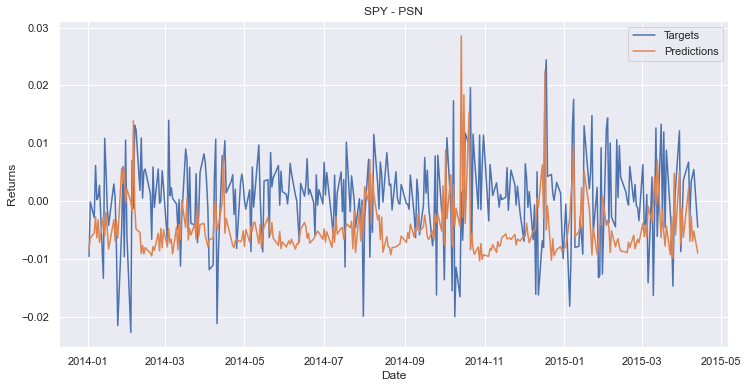




==========DIA - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.019548 / Val Loss : 1.002020
[00:31] Epoch 100/500 - Train Loss : 0.953595 / Val Loss : 1.029403
[01:03] Epoch 200/500 - Train Loss : 0.842662 / Val Loss : 1.054747
[01:34] Epoch 300/500 - Train Loss : 0.764322 / Val Loss : 1.157337
[02:05] Epoch 400/500 - Train Loss : 0.709858 / Val Loss : 1.288409
[02:37] Epoch 500/500 - Train Loss : 0.676685 / Val Loss : 1.326510
Train MAE : 0.6205 | Train MAPE  : 2.7568 | Train RMSE : 0.8081 | Train Theil-U 0.5259
Valid MAE : 0.8919 | Valid MAPE  : 2.5896 | Valid RMSE : 1.1517 | Valid Theil-U 0.7624
Normalized Test MAE : 0.005963 | Test MAPE  : 80.261736 | Test RMSE : 0.007969 | Test Theil-U 0.717752
Test MAE : 0.005979 | Te

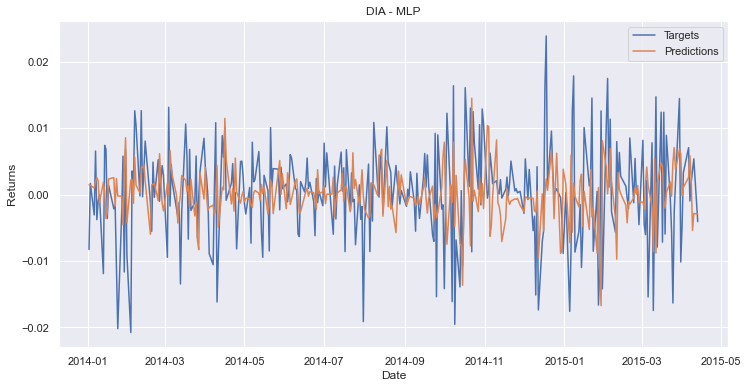




==========DIA - RNN==========
RNN(
  (rnn): RNN(8, 7)
  (fc): Linear(in_features=7, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.006
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.050953 / Val Loss : 1.019617
[00:44] Epoch 100/500 - Train Loss : 0.807993 / Val Loss : 1.369932
[01:29] Epoch 200/500 - Train Loss : 0.733211 / Val Loss : 1.306926
[02:13] Epoch 300/500 - Train Loss : 0.689311 / Val Loss : 1.358853
[02:57] Epoch 400/500 - Train Loss : 0.679183 / Val Loss : 1.361651
[03:41] Epoch 500/500 - Train Loss : 0.673998 / Val Loss : 1.361382
Train MAE : 0.6202 | Train MAPE  : 3.0013 | Train RMSE : 0.8152 | Train Theil-U 0.5107
Valid MAE : 0.9269 | Valid MAPE  : 2.7308 | Valid RMSE : 1.1668 | Valid Theil-U 0.6863
Normalized Test MAE : 0.006625 | Test MAPE  : 544.202206 | Test RMSE : 0.008546 | Test Theil-U 0.705890
Test MAE : 0.006619 | Test MAPE  : 261.664356 | Test RMSE : 0.008517 | Test Theil-U

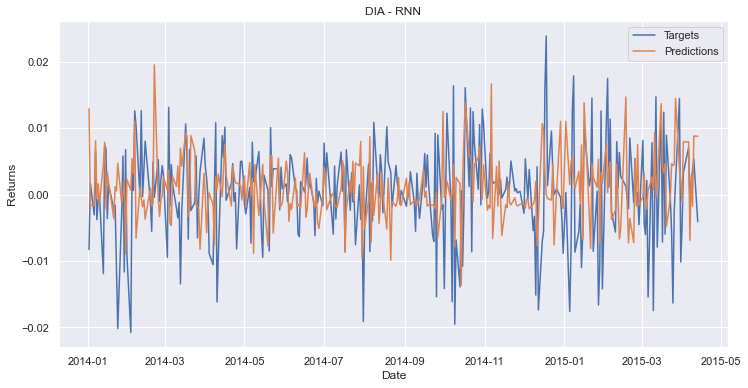




==========DIA - PSN==========
PSN(
  (fc): Linear(in_features=7, out_features=6, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.020694 / Val Loss : 0.013876
[00:30] Epoch 100/200 - Train Loss : 0.013771 / Val Loss : 0.007060
[01:01] Epoch 200/200 - Train Loss : 0.013631 / Val Loss : 0.007263
Train MAE : 0.0856 | Train MAPE  : 0.1639 | Train RMSE : 0.1166 | Train Theil-U 0.1000
Valid MAE : 0.0702 | Valid MAPE  : 0.1169 | Valid RMSE : 0.0852 | Valid Theil-U 0.0736
Normalized Test MAE : 0.006789 | Test MAPE  : 17674.285508 | Test RMSE : 0.008312 | Test Theil-U 0.728432
Test MAE : 0.006789 | Test MAPE  : 342702769927759.500000 | Test RMSE : 0.008312 | Test Theil-U 0.728432


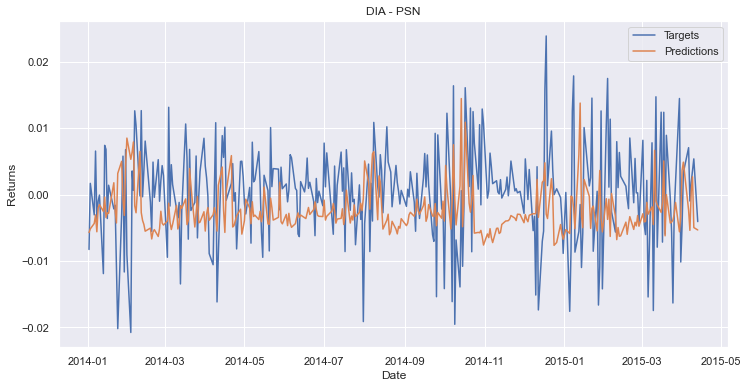




==========QQQ - MLP==========
Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.021375 / Val Loss : 0.993535
[00:32] Epoch 100/500 - Train Loss : 0.926074 / Val Loss : 0.976146
[01:04] Epoch 200/500 - Train Loss : 0.848118 / Val Loss : 1.039327
[01:35] Epoch 300/500 - Train Loss : 0.761462 / Val Loss : 1.109878
[02:06] Epoch 400/500 - Train Loss : 0.735162 / Val Loss : 1.154048
[02:37] Epoch 500/500 - Train Loss : 0.695706 / Val Loss : 1.159487
Train MAE : 0.6351 | Train MAPE  : 3.1178 | Train RMSE : 0.8185 | Train Theil-U 0.5332
Valid MAE : 0.8328 | Valid MAPE  : 2.6609 | Valid RMSE : 1.0768 | Valid Theil-U 0.7082
Normalized Test MAE : 0.007162 | Test MAPE  : 3.739546 | Test RMSE : 0.009509 | Test Theil-U 0.699424
Test MAE : 0.007230 | Tes

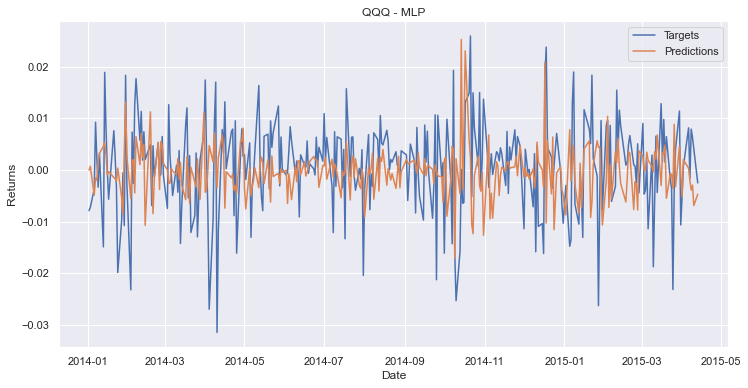




==========QQQ - RNN==========
RNN(
  (rnn): RNN(8, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.005961 / Val Loss : 0.988862
[00:44] Epoch 100/500 - Train Loss : 0.752839 / Val Loss : 1.224030
[01:29] Epoch 200/500 - Train Loss : 0.647038 / Val Loss : 1.337229
[02:22] Epoch 300/500 - Train Loss : 0.609180 / Val Loss : 1.351414
[03:12] Epoch 400/500 - Train Loss : 0.593358 / Val Loss : 1.431174
[04:05] Epoch 500/500 - Train Loss : 0.584597 / Val Loss : 1.513690
Train MAE : 0.5727 | Train MAPE  : 2.4694 | Train RMSE : 0.7485 | Train Theil-U 0.4495
Valid MAE : 0.9271 | Valid MAPE  : 4.8162 | Valid RMSE : 1.2303 | Valid Theil-U 0.6804
Normalized Test MAE : 0.008212 | Test MAPE  : 10.258236 | Test RMSE : 0.010883 | Test Theil-U 0.696810
Test MAE : 0.008262 | Test MAPE  : 276.906172 | Test RMSE : 0.010864 | Test Theil-

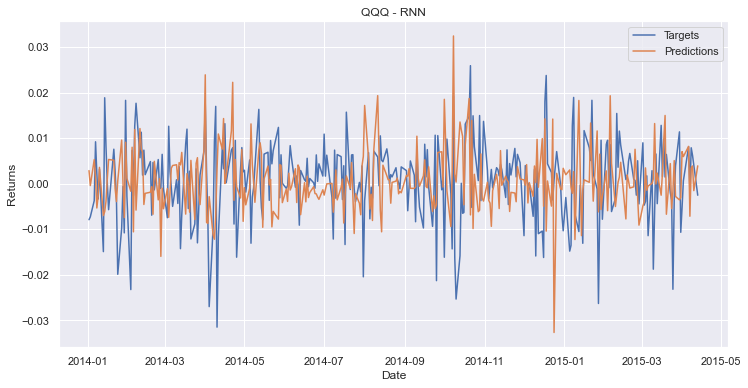




==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.018489 / Val Loss : 0.011347
[00:36] Epoch 100/200 - Train Loss : 0.014313 / Val Loss : 0.005863
[01:10] Epoch 200/200 - Train Loss : 0.014116 / Val Loss : 0.006133
Train MAE : 0.0888 | Train MAPE  : 0.1708 | Train RMSE : 0.1172 | Train Theil-U 0.1027
Valid MAE : 0.0618 | Valid MAPE  : 0.1074 | Valid RMSE : 0.0783 | Valid Theil-U 0.0691
Normalized Test MAE : 0.007467 | Test MAPE  : 4683.670329 | Test RMSE : 0.009280 | Test Theil-U 0.765082
Test MAE : 0.007467 | Test MAPE  : 210332597126421.500000 | Test RMSE : 0.009280 | Test Theil-U 0.765082


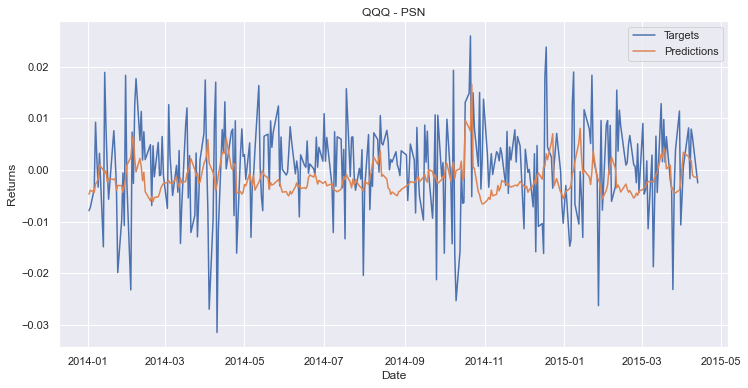

In [5]:
Table4 = pd.DataFrame()

models = {'SPY':{'MLP':None,'RNN':None,'PSN':None},
          'DIA':{'MLP':None,'RNN':None,'PSN':None},
          'QQQ':{'MLP':None,'RNN':None,'PSN':None},
         }

for ETF in ['SPY', 'DIA', 'QQQ']:
    
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']: 
        print("="*10 + ETF + " - " + NNtype + "="*10)
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        elif ETF == "QQQ":
            inputs_lag = cfg.QQQfeatures[NNtype]

        traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
        validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
        testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        
        if NNtype != "PSN":
            trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
            validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
            testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

        else:
            max_ = traindf.Return.max()
            min_ = traindf.Return.min()
            
            traindf = (traindf - min_) / (max_ - min_)
            validdf = (validdf - min_) / (max_ - min_)
            testdf = (testdf - min_) / (max_ - min_)
            
            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)
            
            
        model = NN.Model(NNtype)
        epochs = 200 if NNtype == "PSN" else 500
        model.setup(params["input_size"], 
                    params["hidden_size"],
                    params["output_size"],
                    epochs,#params["epochs"],
                    params["optim"],
                    params["lr"],
                    params["momentum"]
                   )

        model.train(trainloader, validloader)
        
        if NNtype == "PSN":
            model.evaluate(testloader, min_=min_, max_=max_)
            preds = model.predict(testloader, min_=min_, max_=max_)
            labels = testdf["Target"]*(max_ - min_) + min_
        else :
            model.evaluate(testloader, sigma=testsigma, mu=testmu)
            preds = model.predict(testloader, sigma=testsigma, mu=testmu)
            labels = np.array(testdf["Target"].tolist())
        
        testRMSE = np.sqrt(mean_squared_error(labels, preds))
        testMAE = mean_absolute_error(labels, preds)
        testMAPE = 100 * mean_absolute_percentage_error(labels, preds)
        testTheilU = theilU(labels, preds)

        print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))
        
        ## plot Target and Predictions UnNormalized ##
        dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
        dataDf.index = testdf.index
        
        sns.set()
        fig, ax = plt.subplots(figsize = (12,6))
        sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
        sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

#         x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
#         ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
        ax.set_ylabel('Returns')
        ax.set_title(ETF + " - " + NNtype)
        plt.show()
        
        models[ETF][NNtype] = model
        
        Table[NNtype] = [testMAE, testMAPE, testRMSE, testTheilU]
        Table["ETF"] = ETF 
        print("\n"*2)
     
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
# Table4.to_csv("table/Table4norm.csv", index=True) 

### Save Models

In [6]:
for ETF in ["SPY", "DIA", "QQQ"]:
    for NNtype in ["MLP", "RNN", "PSN"]:
        os.makedirs(os.path.join("models_norm", ETF, NNtype), exist_ok=True)
        save_model(models[ETF][NNtype].model.state_dict(), os.path.join("models_norm", ETF, NNtype, "ckpt.pth"))

### Load Ckpt

In [43]:
ETF = "DIA"
NNtype = "MLP"
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype]

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'
df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)

modelloaded = NN.Model(NNtype)
modelloaded.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            1000,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )
modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
modelloaded.evaluate(dataloader)

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.005390 | Test MAPE  : 1.079670 | Test RMSE : 0.007245 | Test Theil-U 0.926919


# To work

# Generating Table 4

In [ ]:
Table4 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          1000,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate(dataloader)
        
        Table[NNtype] = [modelloaded.testMAE, modelloaded.testMAPE, modelloaded.testRMSE, modelloaded.testTheilU]
        Table["ETF"] = ETF
    
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4norm.csv", index=True)        

In [10]:
ypred, ytrue, evaluation = modelloaded.Getevaluation(dataloader)

In [14]:
import numpy as np
y_pred = np.array(ypred)
y_true = np.array(ytrue)

In [51]:
modelloaded.evaluate(dataloader)

Test MAE : 0.005624 | Test MAPE  : inf | Test RSME : 0.000054 | Test Theil-U 0.769070


In [20]:
np.abs((y_true - y_pred)/y_true)

array([5.97504411e-01, 8.19620566e-01, 7.61992324e-01, 1.27961111e+00,
       1.55741931e+00, 1.06965293e+00, 4.08921429e+01, 1.03007374e+00,
       1.17004060e+00, 7.15264093e-01, 6.79977365e-01, 1.38981662e+00,
       5.70637783e-01, 2.21547445e+00, 1.06259083e+00, 8.27917005e-01,
       1.34271908e+00, 1.28133038e+00, 9.69783017e-01, 6.09123871e-01,
       1.31316356e+00, 1.12362061e+00, 4.03105552e-01, 3.35606941e+00,
       7.98431427e-01, 6.87432206e-01, 7.31159248e-01, 3.80845850e-01,
       1.51305376e+00, 1.29509997e+00, 7.20141230e-01, 3.29434595e+00,
       1.13785257e+00, 1.49065573e+00, 3.72291052e+00, 7.72002016e-01,
       6.24651569e-01, 8.43269646e-01, 5.24755104e-01, 1.34105122e+00,
       1.07121130e+00, 9.88006366e-01, 8.68172943e-01, 1.04517050e+00,
       3.42294065e-01, 4.86738036e-01, 1.53935203e+00, 2.25559896e-01,
       8.57544100e-01, 1.52026479e+00, 1.25801378e+00, 6.77532215e-01,
       1.29784225e+00, 7.91556409e-01, 2.08852883e+00, 1.93345424e+00,
      

In [30]:
y_true[y_true == 0] = 0.000006

In [31]:
np.where(y_true == 0)

(array([], dtype=int64),)

In [12]:
Table4

NameError: name 'Table4' is not defined